In [1]:
include("random_clifford/Initial.jl")
include("random_clifford/Symplectic.jl")

reverseCommands (generic function with 1 method)

In [233]:
using Yao
using YaoBlocks
using YaoBlocks.AD
using Random
using PyPlot
using YaoSym
using YaoExtensions
using QuAlgorithmZoo: Adam, update!
using LinearAlgebra
using BenchmarkTools
using Zygote

┌ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1242


In [234]:
include("/Users/arthurpesah/.julia/packages/YaoExtensions/VAbtx/example/port_zygote.jl")
include("/Users/arthurpesah/.julia/packages/YaoExtensions/VAbtx/example/zygote_patch.jl")

## Generate a dataset of random clifford circuit and corresponding energy

### Parameters

In [3]:
n_qubits = 2
n_circuits = 200
n = n_qubits;

### Create random circuits

In [4]:
n_clifford_circuits = max(getNumberOfSymplecticCliffords(n), 2^63-1)

9223372036854775807

In [5]:
function parseCommand(command)
    if command[1] == "hadamard"
        return put(command[2]=>H)
    elseif command[1] == "phase"
        return put(command[2]=>shift(π/2))
    elseif command[1] == "cnot"
        return control(command[2][1], command[2][2]=>X)
    else
        error("The command should be either 'hadamard', 'phase' or 'cnot', not $(command[1])")
    end
end

parseCommand (generic function with 1 method)

In [6]:
function getRandomCircuit(i)
    commands = decompose(rand(0:n_clifford_circuits), rand(0:2^(2*n)), n, true)
    list_commands = map(c -> (c[1], parse.(Int, split(c[2], ","))),
                    split.(commands, r"\(|\)", keepempty=false)[2:length(commands)-1])
    circuit = chain(n_qubits, parseCommand.(list_commands))
    print("$(i) ")
    return circuit
end

getRandomCircuit (generic function with 1 method)

In [112]:
list_circuits = [getRandomCircuit(i) for i in 1:n_circuits];

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

In [113]:
ket"00" |> list_circuits[2]

NotImplementedError{Tuple{DataType,ShiftGate{Float64}}}: NotImplementedError: mat is not implemented for (::DataType, ::ShiftGate{Float64}), please implement this method for your custom type

### Create Hamiltonian

In [114]:
W = 1/n * (UnitUpperTriangular(ones(n, n)) - I)

2×2 UpperTriangular{Float64,Array{Float64,2}}:
 0.0  0.5
  ⋅   0.0

In [115]:
function get_hamiltonian(W::AbstractMatrix)
    nbit = size(W, 1)
    ab = Any[]
    for i=1:nbit,j=i+1:nbit
        if W[i,j] != 0
            push!(ab, W[i,j]*repeat(nbit, Z, [i,j]))
        end
    end
    sum(ab)
end

get_hamiltonian (generic function with 1 method)

In [116]:
hamil = get_hamiltonian(W);

In [117]:
function evaluate_hamiltonian(i)
    print(i);
    print(" ")
    expect(hamil, zero_state(n_qubits) |> list_circuits[i])
end

evaluate_hamiltonian (generic function with 1 method)

### Compute the expectation values

In [118]:
state = zero_state(n_qubits) |> list_circuits[1];

In [119]:
energies = evaluate_hamiltonian.(1:n_circuits);

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

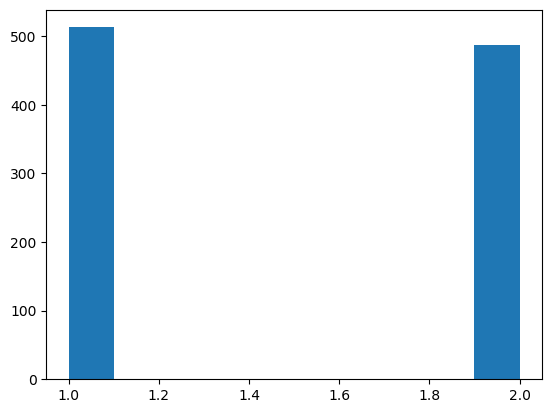

([513.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 487.0], [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9, 2.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x154884c18>, PyObject <matplotlib.patches.Rectangle object at 0x154c07710>, PyObject <matplotlib.patches.Rectangle object at 0x154884e80>, PyObject <matplotlib.patches.Rectangle object at 0x1549a84e0>, PyObject <matplotlib.patches.Rectangle object at 0x1549a87f0>, PyObject <matplotlib.patches.Rectangle object at 0x1549a8b00>, PyObject <matplotlib.patches.Rectangle object at 0x1549a8e10>, PyObject <matplotlib.patches.Rectangle object at 0x1549a8f28>, PyObject <matplotlib.patches.Rectangle object at 0x1549ae470>, PyObject <matplotlib.patches.Rectangle object at 0x1549ae780>])

In [120]:
hist(zero_state(n_qubits) |> list_circuits[4] |> r->Yao.measure(r, nshots=1000))

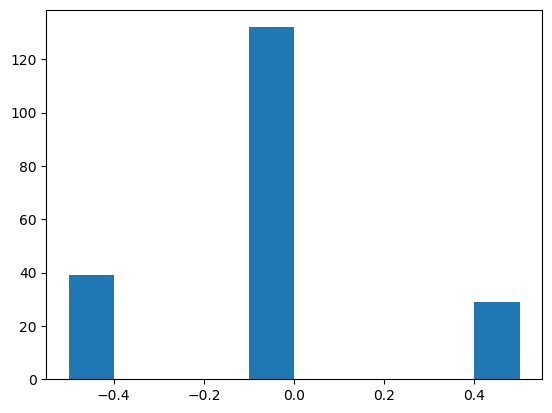

In [121]:
hist(energies);

In [159]:
energies

200-element Array{Complex{Float64},1}:
    -0.49999999999999967 + 0.0im
     -0.4999999999999998 + 0.0im
     0.49999999999999967 + 0.0im
     -0.4999999999999998 + 0.0im
   4.686749320818303e-34 + 0.0im
     -0.4999999999999998 + 0.0im
                     0.0 + 0.0im
 -3.7493994566546427e-33 + 0.0im
                     0.0 + 0.0im
  -3.749399456654642e-33 + 0.0im
      0.4999999999999998 + 0.0im
                     0.0 + 0.0im
                     0.0 + 0.0im
                         ⋮      
     -0.4999999999999998 + 0.0im
     -0.4999999999999998 + 0.0im
                     0.0 + 0.0im
  1.8746997283273247e-33 + 0.0im
                     0.5 + 0.0im
     -0.4999999999999998 + 0.0im
     0.49999999999999967 + 0.0im
                     0.0 + 0.0im
   7.498798913309284e-33 + 0.0im
                     0.0 + 0.0im
                     0.0 + 0.0im
      0.4999999999999998 + 0.0im

### TODO: create a balanced dataset (in terms of energy)

### TODO: Save the dataset

## Variational circuit

### Definition

In [123]:
function U()
    return chain(Rz(0), Rx(0), Rz(0))
end

U (generic function with 1 method)

In [124]:
list_circuits = NoParams.(list_circuits);

In [125]:
parameters(list_circuits[1])

0-element Array{Float64,1}

In [341]:
v_unitary = chain(n, put(1=>Rz(0)), put(1=>Ry(0)), put(1=>Rz(0)), 
                  put(2=>Rz(0)), put(2=>Ry(0)), put(2=>Rz(0)), 
                  control(2, 1=>X), 
                  put(1=>Rz(0)), put(2=>Ry(0)),
                  control(1, 2=>X),
                  put(2=>Ry(0)),
                  control(2, 1=>X),
                  put(1=>Rz(0)), put(1=>Ry(0)), put(1=>Rz(0)), 
                  put(2=>Rz(0)), put(2=>Ry(0)), put(2=>Rz(0)));

v_circuit = chain(n+1, put(1=>H), control(1, 2:n+1=>v_unitary), put(1=>H));
total_circuits = [chain(n+1, concentrate(n+1, circuit, 2:n+1), v_circuit) for circuit in list_circuits];

In [342]:
expect(put(n+1, 1=>Z), zero_state(n+1) |> total_circuits[1])

3.749399456654639e-33 + 0.0im

In [189]:
dispatch!.(v_unitary, :random);
a_param = 1
b_param = 0
# optimizer = Adam(lr=0.005)
list_rmse = Any[]
using Flux.Optimise

0

In [131]:
function predict_energy(i)
    psi = zero_state(n+1) |> total_circuits[i]
    Z1 = put(n+1, 1=>Z)
    return a_param * expect(Z1, psi) + b_param
end

predict_energy (generic function with 1 method)

In [167]:
optimizer = Optimise.Descent(lr)

Descent(0.0001)

In [400]:
function cost(params, a_param, b_param, circuit, real_energy)
    psi = dispatch_diff_apply!(zero_state(n+1), circuit, params)
    Z1 = put(n+1, 1=>Z)
    predicted_energy = a_param * expect(Z1, psi) + b_param
    return 1/2 * (predicted_energy - real_energy)^2
end;

In [401]:
cost(params, a_param, b_param, total_circuits[14], energies[1])

0.1283934641607766 + 0.0im

In [227]:
n_epochs = 100000

lr = 0.1
lr_ab = 0.1
batch_size = 200
optimizer.eta = lr
params = parameters(v_unitary)

for epoch = 1:n_epochs
    mse = 0
    gradient_batch = zeros(length(params))
    gradient_a = 0
    gradient_b = 0
    indices = randperm(MersenneTwister(42), n_circuits)
    for i in indices
        Z1 = put(n+1, 1=>Z)
        residual = predict_energy(i) - energies[i]
        mse += real(residual^2)
        
        grad_input, grad_params = expect'(Z1, zero_state(n+1) => total_circuits[i])
        grad_params *= a_param * residual
        gradient_batch += real(grad_params)
        gradient_a += real(predict_energy(i) * residual)
        gradient_b += real(residual)
#         @show params
        if i % batch_size == 0 || i == n_circuits
            gradient_batch /= batch_size
            gradient_a /= batch_size
            gradient_b /= batch_size
#             dispatch!(v_unitary, params-gradient_batch)
#             params -= 0.0000001 * Float64.(gradient_batch)
            Optimise.update!(optimizer, params, gradient_batch)
            a_param -= lr_ab * gradient_a
            b_param -= lr_ab * gradient_b
            
            dispatch!(v_unitary, params)
            
            gradient_batch = zeros(length(params))
            gradient_a = 0
            gradient_b = 0
        end
    end
    rmse = sqrt(mse / n_circuits)
    push!(list_rmse, rmse)
#     if list_rmse[end] > list_rmse[end - 1]
#         optimizer.eta /= 2
#         lr_ab /= 2
#     end
    println("Epoch $epoch, RMSE = $rmse")
    IJulia.clear_output(true)
end

Epoch 20000, RMSE = 0.1768885733647236


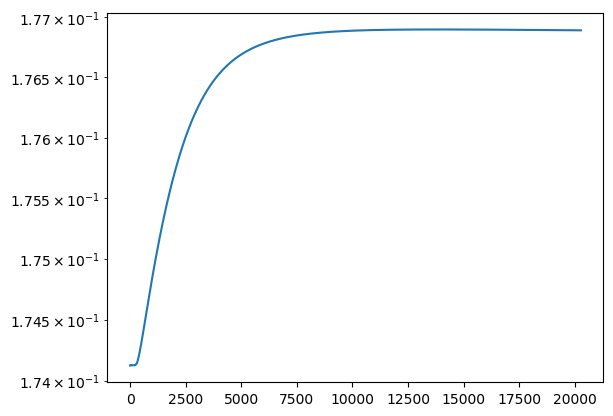

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1576645f8>

In [229]:
semilogy(list_rmse[5000:end])

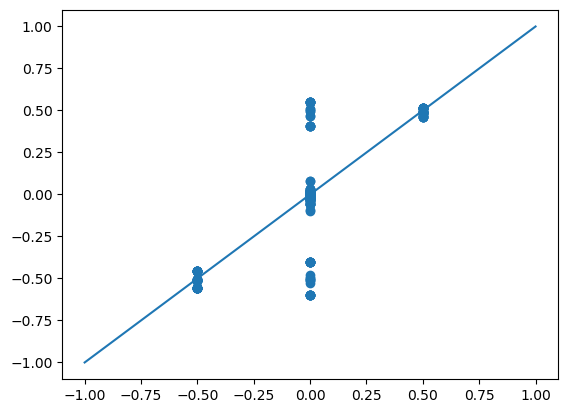

200

PyObject <matplotlib.collections.PathCollection object at 0x1578542e8>

In [232]:
i = 15

psi = [zero_state(n+1) |> c for c in total_circuits]
Z1 = put(n+1, 1=>Z)
pred_energies = [(predict_energy(i) - b_param) / a_param for i in 1:length(psi)]
print(length(pred_energies))
plt.plot([-1, 1], [-1, 1])
plt.scatter(energies, pred_energies)

## Test

In [303]:
i = 15

psi = zero_state(n+1) |> total_circuits[i]
Z1 = put(n+1, 1=>Z)
println("Predicted Energy: $(expect(Z1, psi))")
println("Real Energy: $(energies[i])")

Predicted Energy: 0.4315397404943842 + 0.0im
Real Energy: 0.49999999999999967 + 0.0im


In [74]:
b_param

0.0014762912116976575 - 0.0im

In [73]:
a_param

0.48999209064464455 - 0.0im

In [79]:
a_param

0.48999209064464455 - 0.0im

In [340]:
function U()
    return chain(Rz(0), Ry(0), Rz(0))
end
v_unitary = chain(n, put(1=>Rz(0)), put(1=>Ry(0)), put(1=>Rz(0)), 
                  put(2=>Rz(0)), put(2=>Ry(0)), put(2=>Rz(0)), 
                  control(2, 1=>X), 
                  put(1=>Rz(0)), put(2=>Ry(0)),
                  control(1, 2=>X),
                  put(2=>Ry(0)),
                  control(2, 1=>X),
                  put(1=>Rz(0)), put(1=>Ry(0)), put(1=>Rz(0)), 
                  put(2=>Rz(0)), put(2=>Ry(0)), put(2=>Rz(0)));
c = v_unitary |> autodiff(:BP)

nqubits: 2
chain
├─ [∂] put on (1)
│     └─ rot(Z gate, 0.0)
├─ [∂] put on (1)
│     └─ rot(Y gate, 0.0)
├─ [∂] put on (1)
│     └─ rot(Z gate, 0.0)
├─ [∂] put on (2)
│     └─ rot(Z gate, 0.0)
├─ [∂] put on (2)
│     └─ rot(Y gate, 0.0)
├─ [∂] put on (2)
│     └─ rot(Z gate, 0.0)
├─ control(2)
│  └─ (1,) X gate
├─ [∂] put on (1)
│     └─ rot(Z gate, 0.0)
├─ [∂] put on (2)
│     └─ rot(Y gate, 0.0)
├─ control(1)
│  └─ (2,) X gate
├─ [∂] put on (2)
│     └─ rot(Y gate, 0.0)
├─ control(2)
│  └─ (1,) X gate
├─ [∂] put on (1)
│     └─ rot(Z gate, 0.0)
├─ [∂] put on (1)
│     └─ rot(Y gate, 0.0)
├─ [∂] put on (1)
│     └─ rot(Z gate, 0.0)
├─ [∂] put on (2)
│     └─ rot(Z gate, 0.0)
├─ [∂] put on (2)
│     └─ rot(Y gate, 0.0)
└─ [∂] put on (2)
      └─ rot(Z gate, 0.0)
